# Deciding on targets

We don't know the specific pointings of the individual programs we will be commensal with.  Many of the pointings haven't been decided by the Large Survey Programs (LSPs) yet.  So we need to make our target lists as general as possible to get us to 1M targets, while being flexible enough to adapt to the individual LPSs.

The observing programs vary greatly with respect to survey area and observing time.  Some will cover a large area with shorter time, some will go much deeper on smaller areas.  For a discussion on the observing programs, see other notebooks.

The total area covered by the MeerKAT Field of View (FOV) and LSPs is 360 deg in RA, +20 to -60 deg in Decl: 360X80 = 28,800 square degrees.  The MeerKAT beam is ~1 sq degree in L-Band (1.4GHz) (given by $\theta = 1.22 \frac{\lambda}{d}$ with $d = 13.5 m$).  If the survey is shallow with lots of pointings, we will want a large number of targets, which won't go very deep in distance.  If the survey is deep with a lot of time devoted to a small area, we will want more targets within a single pointing, which will go deeper in distance. 

If we want to get to 1M targets, there are several general ways to get there.<br>
1 - 100 stars per pointing times 10,000 pointings = 1M <- Large area, a lot of pointings, not very deep<br>
2 - 1000 stars per pointing times 1000 pointings = 1M <- Smaller area, fewer pointings, deeper<br>
3 - 10000 stars per pointing times 100 pointings = 1M <- Even smaller<br>

Here I'm going to find the target list conditions which will generate these scenarios for any randomly chosen RA/Dec.

In [1]:
import pandas as pd
import numpy as np
import MySQLdb
import os
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
from astropy import units as u
import numpy as np

### Establish the connection to the SQL database hosting the master Gaia target list
All targets in the Gaia catalog which meet our specified data quality requirements<br>
-Note: my login credentials are stored in the my.cnf file.  You will need your own login credentials to access the database

In [2]:
db = MySQLdb.connect(host='104.154.94.28',db='loganp',\
                     read_default_file="~/.my.cnf",\
                     autocommit=True,\
                     local_infile = 1)
c=db.cursor()

### Define the target retrieving function

In [32]:
def get_targets(ra,deg,ang_diam=0.8,dist=5000,con=db,database='master_gaia_database'):
    """
    Given an RA/Dec array of any size, returns a Pandas databse of
    the targets from the master database that fall within 
    a circle of specified angular diameter of the given RA/Decs
    All angles in degrees
    Args:
        ra,dec (array, float [deg]): arrays of pointing coordinates in decimal degrees
        ang_diam (float [deg]): angular size of the diameter of the beam you are simulating.  Default of 0.8 deg
                          is slightly smaller than the MeerKAT beam in L-band to provide a conservative estimate
        dist (float, [pc]): depth of the desired query in parsecs.  Default is set larger than the largest distance
                          in the master database to return essentially no distance cut
        con (MySQL connection object): the connection you would like to use for the retrieval
        database (str): the database to query.  Default is the master database of all Gaia targets in our program
    Returns:
        Pandas dataframe of every object in the database meeting criteria
    """
    index = range(len(ra))
    appended_data = [] #make a list to store dataframes
    for r,d,i in zip(ra,deg,index):
        string = 'SELECT * FROM '+str(database)+' \
                    WHERE POWER((ra-('+str(r)+')),2) + POWER((decl - ('+str(d)+')),2) < '+str((ang_diam/2.)**2)+' \
                    AND `dist.c` <= '+str(dist)+';'
        dataframe = pd.read_sql(string, con=con)
        # store DataFrame in list
        appended_data.append(dataframe)
        print "I've done ",i+1," of ",len(ra)," total pointings"
    targets = pd.concat(appended_data, axis=0)
    return targets

## Scenario 1 - 100 stars per pointing

If we limit the distance of the query to only objects closer than 600 pc, we will get on average around 100 stars in a given pointing.

Total number of targets:  6504098


<IPython.core.display.Javascript object>


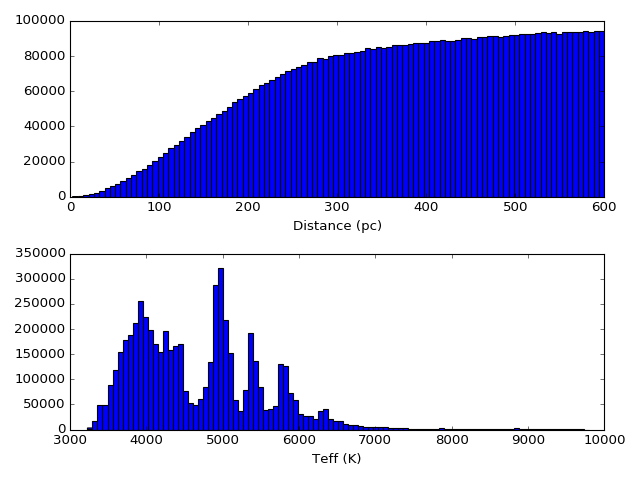

In [6]:
dist_lim = 600
string = 'SELECT ra,decl,teff_val,`dist.c` FROM master_gaia_database_meerkat_fov \
                    WHERE `dist.c` < '+str(dist_lim)+';'
# This line uses Pandas to execute the query and return a Pandas dataframe of the results:
df = pd.read_sql(string, con=db)
print 'Total number of targets: ',df.shape[0]

# Make a plot of distance and Teff of the returned results
%matplotlib notebook
plt.subplot(211)
plt.hist(df['dist.c'],bins=100)
plt.xlabel('Distance (pc)')
plt.subplot(212)
# Not all sources in Gaia have estimated Teff values, take only the ones that do for the histogram:
plt.hist(df['teff_val'].values[(np.where(df['teff_val'].values!=0)[0])],bins=100)
plt.xlabel('Teff (K)')
plt.tight_layout()
plt.show()
plt.savefig('dist_lim_'+str(dist_lim)+'.png',format='png')

<IPython.core.display.Javascript object>


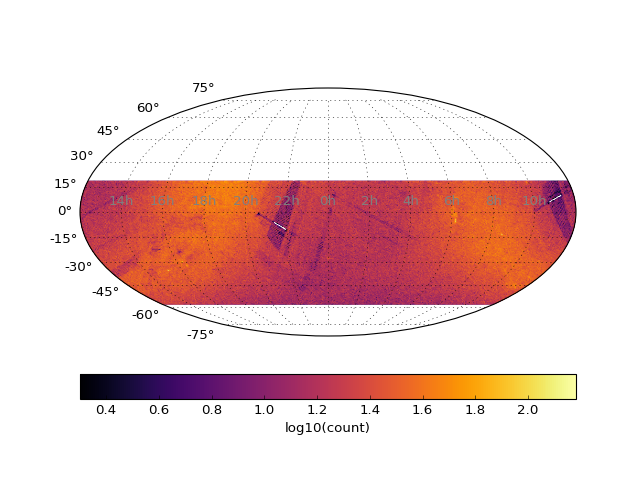

In [7]:
# Mollweide plot of those objects:

import astropy.coordinates as coord
pra = coord.Angle(df['ra'].values*u.degree)
pra = pra.wrap_at(180*u.degree)
pdec = coord.Angle(df['decl'].values*u.degree)

%matplotlib notebook
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
hb = ax.hexbin(pra.radian, pdec.radian,gridsize=500,cmap='inferno',bins='log',mincnt=1)
#ax.scatter(pra.radian, pdec.radian,alpha=0.2,color='blue',s=5)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'],color='grey')
#ax.set_title('Nearest 1M stars in RA/Dec projection\n')
cb = fig.colorbar(hb, ax=ax,orientation="horizontal", pad=0.1)
cb.set_label('log10(count)')
ax.grid(True)
plt.show()
plt.savefig('dist_lim_'+str(dist_lim)+'mollweide.png',format='png')

In order to simulate randomly selecting pointings, I'm going to make a grid of ~1000 points within the FOV

(32, 32) (32, 32)


<IPython.core.display.Javascript object>


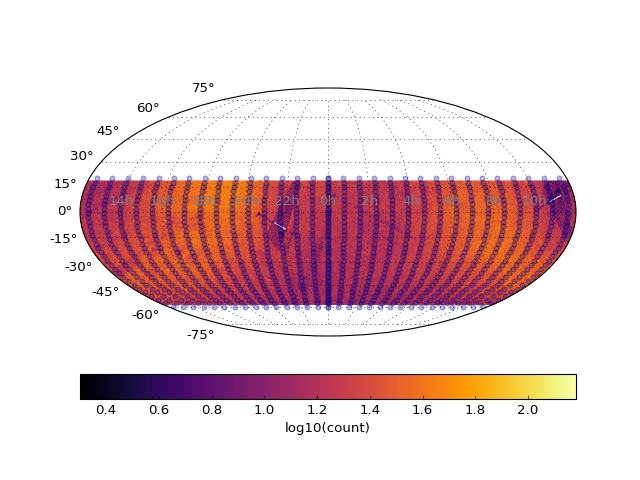

In [9]:
# Grid of 1000 evenly spaced points:
raarray = np.linspace(0,360,32)
decarray = np.linspace(20,-60,32)
r = coord.Angle(raarray*u.degree)
d = coord.Angle(decarray*u.degree)

# make a grid:
rr, dd = np.meshgrid(r, d)
print rr.shape,dd.shape
# Overlay the grid over the plot of all objects in the FOV:
%matplotlib notebook
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
hb = ax.hexbin(pra.radian, pdec.radian,gridsize=500,cmap='inferno',bins='log',mincnt=1)
# For plotting only, we have to wrap the RA values at 180 deg:
r_wrap = r.wrap_at(180*u.degree)
rr_wrap, dd = np.meshgrid(r_wrap, d)
ax.scatter(rr_wrap.radian,dd.radian,alpha=0.3)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'],color='grey')
#ax.set_title('Nearest 1M stars in RA/Dec projection\n')
cb = fig.colorbar(hb, ax=ax,orientation="horizontal", pad=0.1)
cb.set_label('log10(count)')
ax.grid(True)
plt.show()
#plt.savefig('dist_lim_'+str(dist_lim)+'mollweide_verlay.png',format='png')

Now I will select some of the points randomly and determine how many objects fall within a beam size of that point.  I modified the query to only call "COUNT(*)", which just returns the number of object that meet the WHERE criteria.  I'll just pick ten random points for now.

In [10]:
size=10
index=np.linspace(0,size-1,size)
# create an array of randomly chosen index values:
irand1 = np.random.randint(0,31,size)
irand2 = np.random.randint(0,31,size)

# initialize the count array:
count = np.zeros(size)
database='master_gaia_database_meerkat_fov'
ang_diam=0.8

for i1,i2,i in zip(irand1,irand2,index):
    # Select the random point:
    r=rr.degree[i1][i2]
    d=dd.degree[i1][i2]
    # Query the database
    string = 'SELECT COUNT(*) FROM '+str(database)+' \
                    WHERE POWER((ra-('+str(r)+')),2) + POWER((decl - ('+str(d)+')),2) < \
                    '+str((ang_diam/2.)**2)+' \
                    AND `dist.c` < '+str(dist_lim)+';'
    dataframe = pd.read_sql(string, con=db)
    # Get the count value as a float object and record in the count array:
    count[int(i)] = dataframe['COUNT(*)'].values[0]
    if i%5 == 0:
        print "I've done number",int(i)+1
    if i == max(index):
        print "I'm done."
print count
print np.average(count)

I've done number 1
I've done number 6
I'm done.
[  84.  118.  190.   70.   88.   64.  118.  178.   79.  143.]
113.2


So I get slightly larger than 100 as an average.  That's good!  I'll take it.

This takes a while to do the query and computation.  Here is a "count" array I did on 100 randomly selected points with a distance cut of 600 pc.

<IPython.core.display.Javascript object>


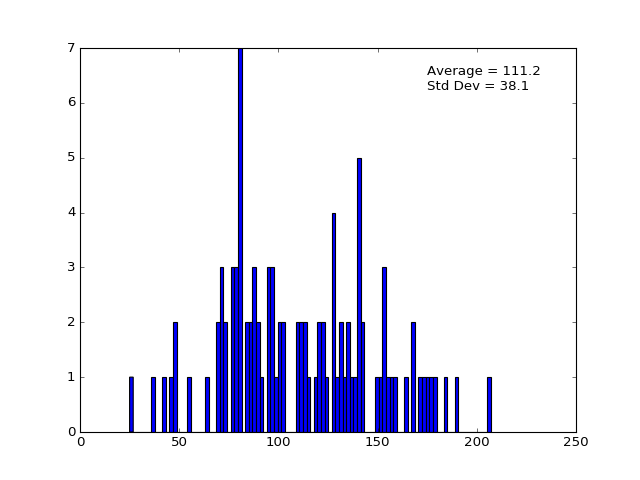

In [31]:
k = pd.read_csv('100_samples_count_600pc.csv')
k = k['0'].values
%matplotlib notebook
plt.hist(k,bins=100)
plt.annotate("Average = {0}\nStd Dev = {1}".format(np.mean(k),np.round(np.std(k),decimals=1)),xy=(0.7,0.89),xycoords='axes fraction')
plt.show()
plt.savefig('100pointings_'+str(dist_lim)+'.png',format='png')

So it's giving around 110 stars per pointing pretty consistently.  With a wide spread.

### A simulated pointing:
Here I will select a point at random and plot the objects within the pointing

I've done  0  of  1  total pointings


<IPython.core.display.Javascript object>


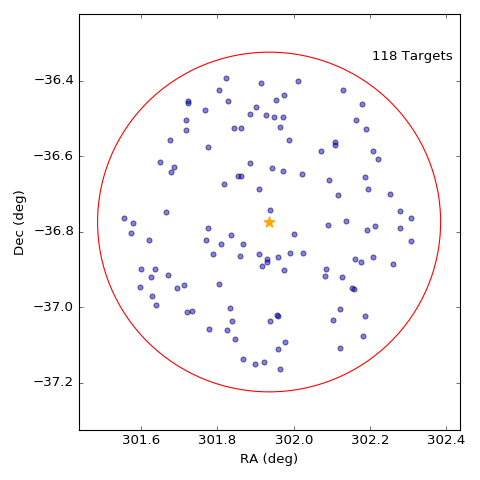

In [26]:
# Select a random point
size=1
irand1 = np.random.randint(0,31,size)
irand2 = np.random.randint(0,31,size)
r=rr.degree[irand1[0]][irand2[0]]
d=dd.degree[irand1[0]][irand2[0]]
# Get all targets within a beam centered at the point:
t1 = get_targets([r],[d],ang_diam=0.8,dist=dist_lim,con=db)

%matplotlib notebook
plt.figure(figsize=(6,6))
a = plt.subplot(111)
plt.scatter(t1['ra'],t1['decl'],alpha=0.5)
plt.scatter(r,d,marker='*',color='orange',s=100)
plt.annotate("{0} Targets".format(t1['ra'].shape[0]),xy=(0.77,0.89),xycoords='axes fraction')
circle = plt.Circle((r,d), 0.45, color='r',fill=False)
a.add_artist(circle)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.xlim(r-0.5,r+0.5)
plt.ylim(d-0.55,d+0.55)
plt.tight_layout()
plt.show() 
#plt.savefig('pointings_600pc_3.png',format='png')

## Scenario 2 - 1000 stars per pointing

I'm going to start with no distance limit and see how many targets on average fall within a random pointing.

Total number of targets:  17234984


<IPython.core.display.Javascript object>


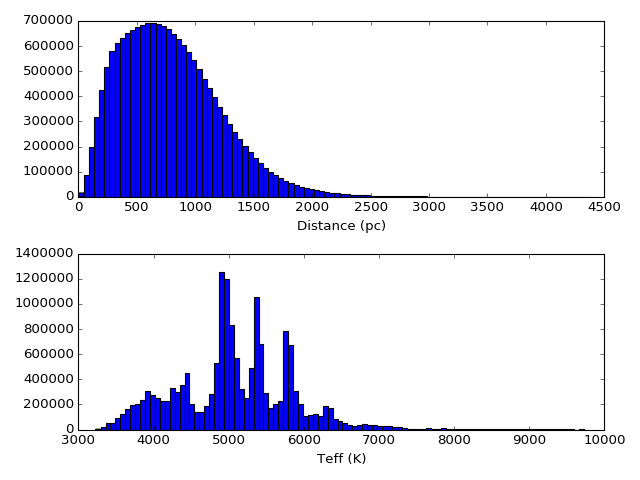

In [27]:
dist_lim = 10000 # Much larger than the max in the database - essentially infinite
string = 'SELECT ra,decl,teff_val,`dist.c` FROM master_gaia_database_meerkat_fov \
                    WHERE `dist.c` < '+str(dist_lim)+';'
# This line uses Pandas to execute the query and return a Pandas dataframe of the results:
df = pd.read_sql(string, con=db)
print 'Total number of targets: ',df.shape[0]

# Make a plot of distance and Teff of the returned results
%matplotlib notebook
plt.subplot(211)
plt.hist(df['dist.c'],bins=100)
plt.xlabel('Distance (pc)')
plt.subplot(212)
# Not all sources in Gaia have estimated Teff values, take only the ones that do for the histogram:
plt.hist(df['teff_val'].values[(np.where(df['teff_val'].values!=0)[0])],bins=100)
plt.xlabel('Teff (K)')
plt.tight_layout()
plt.show()
plt.savefig('dist_lim_'+str(dist_lim)+'.png',format='png')

<IPython.core.display.Javascript object>


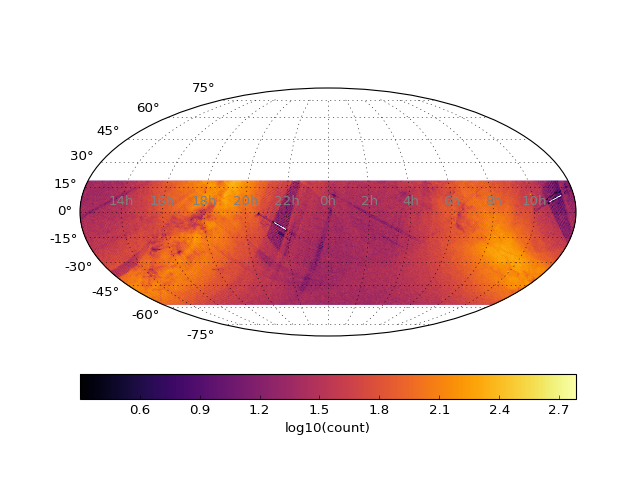

In [28]:
# Mollweide plot of those objects:

import astropy.coordinates as coord
pra = coord.Angle(df['ra'].values*u.degree)
pra = pra.wrap_at(180*u.degree)
pdec = coord.Angle(df['decl'].values*u.degree)

%matplotlib notebook
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
hb = ax.hexbin(pra.radian, pdec.radian,gridsize=500,cmap='inferno',bins='log',mincnt=1)
#ax.scatter(pra.radian, pdec.radian,alpha=0.2,color='blue',s=5)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'],color='grey')
#ax.set_title('Nearest 1M stars in RA/Dec projection\n')
cb = fig.colorbar(hb, ax=ax,orientation="horizontal", pad=0.1)
cb.set_label('log10(count)')
ax.grid(True)
plt.show()
plt.savefig('dist_lim_'+str(dist_lim)+'mollweide.png',format='png')

In [29]:
size=10
index=np.linspace(0,size-1,size)
# create an array of randomly chosen index values:
irand1 = np.random.randint(0,31,size)
irand2 = np.random.randint(0,31,size)

# initialize the count array:
count = np.zeros(size)
database='master_gaia_database_meerkat_fov'
ang_diam=0.8

for i1,i2,i in zip(irand1,irand2,index):
    # Select the random point:
    r=rr.degree[i1][i2]
    d=dd.degree[i1][i2]
    # Query the database
    string = 'SELECT COUNT(*) FROM '+str(database)+' \
                    WHERE POWER((ra-('+str(r)+')),2) + POWER((decl - ('+str(d)+')),2) < \
                    '+str((ang_diam/2.)**2)+' \
                    AND `dist.c` < '+str(dist_lim)+';'
    dataframe = pd.read_sql(string, con=db)
    # Get the count value as a float object and record in the count array:
    count[int(i)] = dataframe['COUNT(*)'].values[0]
    if i%5 == 0:
        print "I've done number",int(i)+1
    if i == max(index):
        print "I'm done."
print count
print np.average(count)

I've done number 1
I've done number 6
I'm done.
[ 537.  364.  171.  832.  118.  154.  151.  656.  350.  310.]
364.3


Hmm.  So, a lot more, but not nearly 1000.  And that's all the targets in the catalog.

I've done  0  of  1  total pointings


<IPython.core.display.Javascript object>


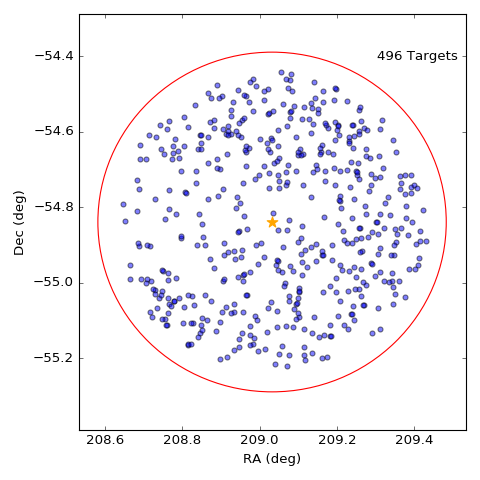

In [30]:
# Select a random point
size=1
irand1 = np.random.randint(0,31,size)
irand2 = np.random.randint(0,31,size)
r=rr.degree[irand1[0]][irand2[0]]
d=dd.degree[irand1[0]][irand2[0]]
# Get all targets within a beam centered at the point:
t1 = get_targets([r],[d],ang_diam=0.8,dist=dist_lim,con=db)

%matplotlib notebook
plt.figure(figsize=(6,6))
a = plt.subplot(111)
plt.scatter(t1['ra'],t1['decl'],alpha=0.5)
plt.scatter(r,d,marker='*',color='orange',s=100)
plt.annotate("{0} Targets".format(t1['ra'].shape[0]),xy=(0.77,0.89),xycoords='axes fraction')
circle = plt.Circle((r,d), 0.45, color='r',fill=False)
a.add_artist(circle)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.xlim(r-0.5,r+0.5)
plt.ylim(d-0.55,d+0.55)
plt.tight_layout()
plt.show() 
plt.savefig('pointings_'+str(dist_lim)+'pc_1.png',format='png')

<IPython.core.display.Javascript object>


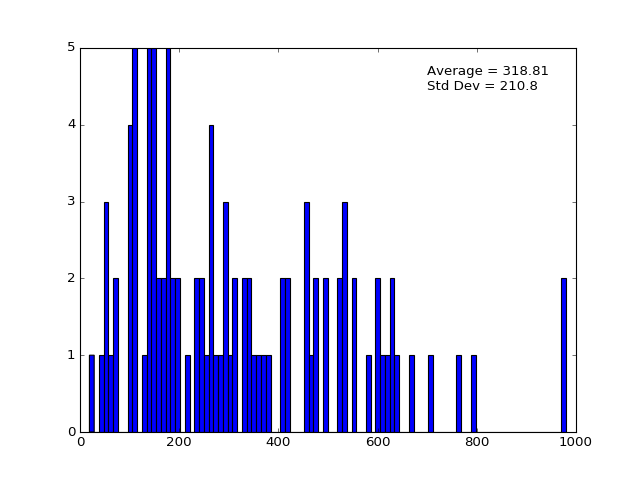

In [37]:
k = pd.read_csv('100_samples_count_10000pc.csv')
k = k['0'].values
%matplotlib notebook
plt.hist(k,bins=100)
plt.annotate("Average = {0}\nStd Dev = {1}".format(np.mean(k),np.round(np.std(k),decimals=1)),xy=(0.7,0.89),xycoords='axes fraction')
plt.show()
plt.savefig('100pointings_'+str(dist_lim)+'.png',format='png')